In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import statsmodels.api
from plotly import express as px
from scipy import stats
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error, r2_score
from xgboost import XGBClassifier
import sys
import io
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import export_graphviz
import pydot
import graphviz
from sklearn.metrics import accuracy_score

In [3]:
# souce code : https://developer.ibm.com/tutorials/learn-regression-algorithms-using-python-and-scikit-learn/
def two_d_compare(X_test,y_test,y_pred,model_name):
    area = (12 * np.random.rand(40))**2 
    plt.subplots(ncols=2, figsize=(10,4))
    plt.suptitle('Actual vs Predicted data : ' +model_name + '. Variance score: %.2f' % r2_score(y_test, y_pred))

    plt.subplot(121)
    plt.scatter(X_test, y_test, alpha=0.8, color='#8CCB9B')
    plt.title('Actual')

    plt.subplot(122)
    plt.scatter(X_test, y_pred,alpha=0.8, color='#E5E88B')
    plt.title('Predicted')

    plt.show()
    

def model_metrics(regressor,y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    print("Mean squared error: %.2f"
      % mse)
    r2 = r2_score(y_test, y_pred)
    print('R2 score: %.2f' % r2 )
    return [mse, r2]

def two_vs_three(x_test,y_test,y_pred,z=None, isLinear = False) : 
    
    area = 60
    

    fig = plt.figure(figsize=(12,6))
    fig.suptitle('2D and 3D view of price data')

    # First subplot
    ax = fig.add_subplot(1, 2,1)
    ax.scatter(x_test, y_test, alpha=0.5,color='blue', s= area)
    ax.plot(x_test, y_pred, alpha=0.9,color='red', linewidth=2)
    ax.set_xlabel('availability_365')
    ax.set_ylabel('PRICE')
    # plt.xlim(0, 500)
    # plt.ylim(0, 5000)
    plt.title('availability_365 vs PRICE')
    
    if not isLinear : 
    # Second subplot
        ax = fig.add_subplot(1,2,2, projection='3d')

        ax.scatter(z, x_test, y_test, color='blue', marker='o')
        ax.plot(z, x_test, y_pred, alpha=0.9,color='red', linewidth=2)
        ax.set_ylabel('availability_365')
        ax.set_zlabel('PRICE')
        ax.set_xlabel('host_total_listings_count')

    plt.title('host_total_listings_count vs availability_365 vs PRICE')

    plt.show()

In [4]:
 def cat_cont_correlation_ratio(categories, values):
        """
        Correlation Ratio: https://en.wikipedia.org/wiki/Correlation_ratio
        SOURCE:
        1.) https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9  # noqa
        :param categories: Numpy array of categories
        :param values: Numpy array of values
        :return: correlation
        """
        f_cat, _ = pd.factorize(categories)
        cat_num = np.max(f_cat) + 1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        for i in range(0, cat_num):
            cat_measures = values[np.argwhere(f_cat == i).flatten()]
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(
            n_array
        )  # noqa
        numerator = np.sum(
            np.multiply(
                n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)
            )  # noqa
        )
        denominator = np.sum(np.power(np.subtract(values, y_total_avg), 2))
        if numerator == 0:
            eta = 0.0
        else:
            eta = np.sqrt(numerator / denominator)
        return eta

In [5]:
def cat_correlation(x, y, bias_correction=True, tschuprow=False):
    """
    Calculates correlation statistic for categorical-categorical association. # noqa
    The two measures supported are:
    1. Cramer'V ( default )
    2. Tschuprow'T

    SOURCES:
    1.) CODE: https://github.com/MavericksDS/pycorr
    2.) Used logic from:
        https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
        to ignore yates correction factor on 2x2
    3.) Haven't validated Tschuprow

    Bias correction and formula's taken from : https://www.researchgate.net/publication/270277061_A_bias-correction_for_Cramer's_V_and_Tschuprow's_T # noqa

    Wikipedia for Cramer's V: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V # noqa
    Wikipedia for Tschuprow' T: https://en.wikipedia.org/wiki/Tschuprow%27s_T # noqa
    Parameters:
    -----------
    x : list / ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    bias_correction : Boolean, default = True
    tschuprow : Boolean, default = False
               For choosing Tschuprow as measure
    Returns:
    --------
    float in the range of [0,1]
    """
    corr_coeff = np.nan
    try:
        # x, y = fill_na(x), fill_na(y)
        crosstab_matrix = pd.crosstab(x, y)
        n_observations = crosstab_matrix.sum().sum()

        yates_correct = True
        if bias_correction:
            if crosstab_matrix.shape == (2, 2):
                yates_correct = False

        chi2, _, _, _ = stats.chi2_contingency(
            crosstab_matrix, correction=yates_correct
        )
        phi2 = chi2 / n_observations

        # r and c are number of categories of x and y
        r, c = crosstab_matrix.shape
        if bias_correction:
            phi2_corrected = max(
                0, phi2 - ((r - 1) * (c - 1)) / (n_observations - 1)
            )
            r_corrected = r - ((r - 1) ** 2) / (n_observations - 1)
            c_corrected = c - ((c - 1) ** 2) / (n_observations - 1)
            if tschuprow:
                corr_coeff = np.sqrt(
                    phi2_corrected
                    / np.sqrt((r_corrected - 1) * (c_corrected - 1))  # noqa
                )
                return corr_coeff
            corr_coeff = np.sqrt(
                phi2_corrected / min((r_corrected - 1), (c_corrected - 1))
            )
            return corr_coeff
        if tschuprow:
            corr_coeff = np.sqrt(phi2 / np.sqrt((r - 1) * (c - 1)))
            return corr_coeff
        corr_coeff = np.sqrt(phi2 / min((r - 1), (c - 1)))
        return corr_coeff
    except Exception as ex:
        print(ex)
        if tschuprow:
            warnings.warn("Error calculating Tschuprow's T", RuntimeWarning)  # noqa
        else:
            warnings.warn("Error calculating Cramer's V", RuntimeWarning)
        return corr_coeff

In [6]:
def plot_feature_importance(importance,names,model_type):
    # souece https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [36]:
room = pd.read_csv("https://raw.githubusercontent.com/alex31425/GEOG594-MTHuang/master/RoomF.csv")
room.drop(['host_id'],axis=1,inplace=True)
objcolumn = room.dtypes[room.dtypes == object]
objcolumn = list(objcolumn.index)
room = pd.get_dummies(room, columns=objcolumn)
room = room.dropna()
room.head()

price  number_of_reviews  calculated_host_listings_count  availability_365  \
0    161                  0                               1                89   
1     39                 16                               5                 0   
2     39                  1                               1                87   
3     55                  5                               2                 0   
4     55                  8                               2                 0   

   host_since_days  host_total_listings_count  accommodates  bathrooms  \
0             1396                          1             2        1.0   
1             1217                          5             1        1.0   
2              728                          1             4       15.0   
3             2544                          2             2        1.0   
4             2544                          2             1        1.0   

   bedrooms  beds  ...  host_is_superhost_f  host_is_superhost_t  \
0       1.0   1.0  ...                    1                    0   
1       1.0   1.0  ...                    1                    0   
2       2.0   1.0  ...                    1                    0   
3       1.0   1.0  ...                    1                    0   
4       1.0   1.0  ...                    1                    0   

   host_has_profile_pic_f  host_has_profile_pic_t  host_identity_verified_f  \
0                       0                       1                         1   
1                       0                       1                         1   
2                       0                       1                         0   
3                       0                       1                         0   
4                       0                       1                         0   

   host_identity_verified_t  instant_bookable_f  instant_bookable_t  \
0                         0                   1                   0   
1                         0                   1                   0   
2                         1                   0                   1   
3                         1                   1                   0   
4                         1                   1                   0   

   govermentIdentification_no  govermentIdentification_yes  
0                           1                            0  
1                           1                            0  
2                           0                            1  
3                           0                            1  
4                           0                            1  

[5 rows x 27 columns]

In [37]:
room.columns

Index(['price', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365', 'host_since_days', 'host_total_listings_count',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'avg_rm',
       'availability_30', 'availability_60', 'availability_90',
       'number_of_reviews_ltm', 'NumberOfVerfication', 'numberofamentities',
       'host_is_superhost_f', 'host_is_superhost_t', 'host_has_profile_pic_f',
       'host_has_profile_pic_t', 'host_identity_verified_f',
       'host_identity_verified_t', 'instant_bookable_f', 'instant_bookable_t',
       'govermentIdentification_no', 'govermentIdentification_yes'],
      dtype='object')

d:\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



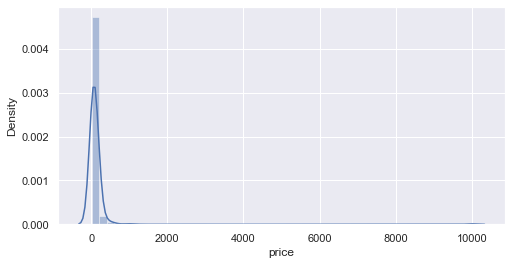

In [38]:
sns.set(rc={"figure.figsize": (8, 4)})
ax = sns.distplot(room['price'])
plt.show()

In [39]:
print("The dataset contains columns of the following data types : \n" +str(room.dtypes))

The dataset contains columns of the following data types : 
price                               int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
host_since_days                     int64
host_total_listings_count           int64
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
beds                              float64
avg_rm                            float64
availability_30                     int64
availability_60                     int64
availability_90                     int64
number_of_reviews_ltm               int64
NumberOfVerfication                 int64
numberofamentities                  int64
host_is_superhost_f                 uint8
host_is_superhost_t                 uint8
host_has_profile_pic_f              uint8
host_has_profile_pic_t              uint8
host_identity_verified_f            uint8
host_identity_ve

In [40]:
print("The dataset contains following number of records for each of the columns : \n" +str(room.count()))

The dataset contains following number of records for each of the columns : 
price                             2967
number_of_reviews                 2967
calculated_host_listings_count    2967
availability_365                  2967
host_since_days                   2967
host_total_listings_count         2967
accommodates                      2967
bathrooms                         2967
bedrooms                          2967
beds                              2967
avg_rm                            2967
availability_30                   2967
availability_60                   2967
availability_90                   2967
number_of_reviews_ltm             2967
NumberOfVerfication               2967
numberofamentities                2967
host_is_superhost_f               2967
host_is_superhost_t               2967
host_has_profile_pic_f            2967
host_has_profile_pic_t            2967
host_identity_verified_f          2967
host_identity_verified_t          2967
instant_bookable_f         

In [41]:
room.isnull().any()

price                             False
number_of_reviews                 False
calculated_host_listings_count    False
availability_365                  False
host_since_days                   False
host_total_listings_count         False
accommodates                      False
bathrooms                         False
bedrooms                          False
beds                              False
avg_rm                            False
availability_30                   False
availability_60                   False
availability_90                   False
number_of_reviews_ltm             False
NumberOfVerfication               False
numberofamentities                False
host_is_superhost_f               False
host_is_superhost_t               False
host_has_profile_pic_f            False
host_has_profile_pic_t            False
host_identity_verified_f          False
host_identity_verified_t          False
instant_bookable_f                False
instant_bookable_t                False


 ## Data preparation

In [42]:
df_room = pd.DataFrame.from_records(room.values)

X = df_room.iloc[:, 1:].to_numpy()
y = df_room.iloc[:, 0].to_numpy()
f = list(room.columns)
f.remove('price')
df_room.head()

0     1    2     3       4    5    6     7    8    9   ...   17   18  \
0  161.0   0.0  1.0  89.0  1396.0  1.0  2.0   1.0  1.0  1.0  ...  1.0  0.0   
1   39.0  16.0  5.0   0.0  1217.0  5.0  1.0   1.0  1.0  1.0  ...  1.0  0.0   
2   39.0   1.0  1.0  87.0   728.0  1.0  4.0  15.0  2.0  1.0  ...  1.0  0.0   
3   55.0   5.0  2.0   0.0  2544.0  2.0  2.0   1.0  1.0  1.0  ...  1.0  0.0   
4   55.0   8.0  2.0   0.0  2544.0  2.0  1.0   1.0  1.0  1.0  ...  1.0  0.0   

    19   20   21   22   23   24   25   26  
0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  
1  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  
2  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  
3  0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  
4  0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  

[5 rows x 27 columns]

In [43]:
# Determine if response is continuous or boolean

if y.dtype is str or bool is True:
    response_type = "boolean"
    print("---Response is boolean---")
elif np.unique(y).size < 5:
    response_type = "boolean"
    print("---Response is boolean---")
else:
    response_type = "continuous"
    print("---Response is continuous---")

---Response is continuous---


In [45]:
# Determine if the predictor continuous or boolean &
# create plots for each variable type
predictor_type = []
con_array = np.array([])
cat_array = np.array([])
for idx, column in enumerate(X.T):

    feature_name = f[idx]
    predictor = statsmodels.api.add_constant(column)

    # Get the stats & plot

    if np.unique(X.T[idx]).size < 5:
        v_type = "boolean"
        cat_array = np.append(cat_array, column)
        print(f[idx], "is boolean" )
        if response_type == "continuous":

            logistic_regression_model = statsmodels.api.GLM(y, predictor)
            logistic_regression_model_fitted = (
                logistic_regression_model.fit()
            )  # noqa
            print(f"Variable: {feature_name}")
            print(logistic_regression_model_fitted.summary(), '\n')
            t_value = round(logistic_regression_model_fitted.tvalues[1], 6)
            p_value = "{:.6e}".format(
                logistic_regression_model_fitted.pvalues[1]
            )  # noqa

            # Categorical Predictor by Continuous Response

            fig = px.histogram(x=column, y=y, histfunc="count")
            fig.update_layout(
                title=f"Variable: {feature_name}: (t-value={t_value}) (p-value={p_value})",  # noqa
                xaxis_title=f"Variable: {feature_name}",
                yaxis_title="Response",
            )
            fig.show()

        else:

            logistic_regression_model = statsmodels.api.GLM(y, predictor)
            logistic_regression_model_fitted = (
                logistic_regression_model.fit()
            )  # noqa
            print(f"Variable: {feature_name}")
            print(logistic_regression_model_fitted.summary(), '\n')
            t_value = round(logistic_regression_model_fitted.tvalues[1], 6)
            p_value = "{:.6e}".format(
                logistic_regression_model_fitted.pvalues[1]
            )  # noqa

            # Categorical Predictor by Continuous Response

            fig = px.scatter(x=column, y=y)
            fig.update_layout(
                title=f"Variable: {feature_name}: (t-value={t_value}) (p-value={p_value})",  # noqa
                xaxis_title=f"Variable: {feature_name}",
                yaxis_title="y",
            )
            fig.show()
    else:
        print(f[idx], "is continuous")
        v_type = "continuous"
        con_array = np.append(cat_array, column)  # noqa
        if response_type == "continuous":

            linear_regression_model = statsmodels.api.OLS(y, predictor)
            linear_regression_model_fitted = linear_regression_model.fit()
            print(f"Variable: {feature_name}")
            print(linear_regression_model_fitted.summary(), '\n')
            t_value = round(linear_regression_model_fitted.tvalues[1], 6)
            p_value = "{:.6e}".format(
                linear_regression_model_fitted.pvalues[1]
            )  # noqa

            # Continuous Predictor by Continuous Response
            # Plot the figure
            fig = px.scatter(x=column, y=y)
            fig.update_layout(
                title=f"Variable: {feature_name}: (t-value={t_value}) (p-value={p_value})",  # noqa
                xaxis_title=f"Variable: {feature_name}",
                yaxis_title="y",
            )
            fig.show()
        else:
            linear_regression_model = statsmodels.api.OLS(y, predictor)
            linear_regression_model_fitted = linear_regression_model.fit()
            print(f"Variable: {feature_name}")
            print(linear_regression_model_fitted.summary(), '\n')
            t_value = round(linear_regression_model_fitted.tvalues[1], 6)
            p_value = "{:.6e}".format(
                linear_regression_model_fitted.pvalues[1]
            )  # noqa
            # Continuous Predictor by Categorical Response
            # Plot the figure
            fig = px.histogram(x=column, y=y)
            fig.update_layout(
                title=f"Variable: {feature_name}: (t-value={t_value}) (p-value={p_value})",  # noqa
                xaxis_title=f"Variable: {feature_name}",
                yaxis_title="y",
            )
            fig.show()
    # create a list of each variable type
    predictor_type.append(v_type)
pd_PT = pd.DataFrame(predictor_type, columns=["type"])


number_of_reviews is continuous
Variable: number_of_reviews
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.289
Date:                Fri, 20 Nov 2020   Prob (F-statistic):             0.0215
Time:                        15:39:59   Log-Likelihood:                -22974.
No. Observations:                2967   AIC:                         4.595e+04
Df Residuals:                    2965   BIC:                         4.596e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

calculated_host_listings_count is continuous
Variable: calculated_host_listings_count
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     27.75
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           1.48e-07
Time:                        15:39:59   Log-Likelihood:                -22963.
No. Observations:                2967   AIC:                         4.593e+04
Df Residuals:                    2965   BIC:                         4.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

availability_365 is continuous
Variable: availability_365
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     19.62
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           9.81e-06
Time:                        15:39:59   Log-Likelihood:                -22967.
No. Observations:                2967   AIC:                         4.594e+04
Df Residuals:                    2965   BIC:                         4.595e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

host_since_days is continuous
Variable: host_since_days
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     18.34
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           1.91e-05
Time:                        15:39:59   Log-Likelihood:                -22967.
No. Observations:                2967   AIC:                         4.594e+04
Df Residuals:                    2965   BIC:                         4.595e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

host_total_listings_count is continuous
Variable: host_total_listings_count
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.895
Date:                Fri, 20 Nov 2020   Prob (F-statistic):              0.169
Time:                        15:39:59   Log-Likelihood:                -22976.
No. Observations:                2967   AIC:                         4.596e+04
Df Residuals:                    2965   BIC:                         4.597e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

accommodates is continuous
Variable: accommodates
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     27.70
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           1.51e-07
Time:                        15:39:59   Log-Likelihood:                -22963.
No. Observations:                2967   AIC:                         4.593e+04
Df Residuals:                    2965   BIC:                         4.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

bathrooms is continuous
Variable: bathrooms
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.04007
Date:                Fri, 20 Nov 2020   Prob (F-statistic):              0.841
Time:                        15:39:59   Log-Likelihood:                -22977.
No. Observations:                2967   AIC:                         4.596e+04
Df Residuals:                    2965   BIC:                         4.597e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

bedrooms is continuous
Variable: bedrooms
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.441
Date:                Fri, 20 Nov 2020   Prob (F-statistic):             0.0637
Time:                        15:39:59   Log-Likelihood:                -22975.
No. Observations:                2967   AIC:                         4.595e+04
Df Residuals:                    2965   BIC:                         4.597e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

beds is continuous
Variable: beds
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     14.32
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           0.000157
Time:                        15:40:00   Log-Likelihood:                -22969.
No. Observations:                2967   AIC:                         4.594e+04
Df Residuals:                    2965   BIC:                         4.595e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.0

avg_rm is continuous
Variable: avg_rm
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1585
Date:                Fri, 20 Nov 2020   Prob (F-statistic):              0.691
Time:                        15:40:00   Log-Likelihood:                -22976.
No. Observations:                2967   AIC:                         4.596e+04
Df Residuals:                    2965   BIC:                         4.597e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1

availability_30 is continuous
Variable: availability_30
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     26.28
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           3.15e-07
Time:                        15:40:00   Log-Likelihood:                -22963.
No. Observations:                2967   AIC:                         4.593e+04
Df Residuals:                    2965   BIC:                         4.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

availability_60 is continuous
Variable: availability_60
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     20.82
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           5.26e-06
Time:                        15:40:00   Log-Likelihood:                -22966.
No. Observations:                2967   AIC:                         4.594e+04
Df Residuals:                    2965   BIC:                         4.595e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

availability_90 is continuous
Variable: availability_90
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     16.96
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           3.92e-05
Time:                        15:40:00   Log-Likelihood:                -22968.
No. Observations:                2967   AIC:                         4.594e+04
Df Residuals:                    2965   BIC:                         4.595e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

number_of_reviews_ltm is continuous
Variable: number_of_reviews_ltm
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5517
Date:                Fri, 20 Nov 2020   Prob (F-statistic):              0.458
Time:                        15:40:00   Log-Likelihood:                -22976.
No. Observations:                2967   AIC:                         4.596e+04
Df Residuals:                    2965   BIC:                         4.597e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

NumberOfVerfication is continuous
Variable: NumberOfVerfication
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     31.10
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           2.67e-08
Time:                        15:40:00   Log-Likelihood:                -22961.
No. Observations:                2967   AIC:                         4.593e+04
Df Residuals:                    2965   BIC:                         4.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

numberofamentities is continuous
Variable: numberofamentities
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     11.49
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           0.000710
Time:                        15:40:00   Log-Likelihood:                -22971.
No. Observations:                2967   AIC:                         4.595e+04
Df Residuals:                    2965   BIC:                         4.596e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

host_is_superhost_f is boolean
Variable: host_is_superhost_f
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1054e+05
Method:                          IRLS   Log-Likelihood:                -22969.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2076e+08
Time:                        15:40:00   Pearson chi2:                 9.21e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

host_is_superhost_t is boolean
Variable: host_is_superhost_t
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1054e+05
Method:                          IRLS   Log-Likelihood:                -22969.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2076e+08
Time:                        15:40:00   Pearson chi2:                 9.21e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

host_has_profile_pic_f is boolean
Variable: host_has_profile_pic_f
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1203e+05
Method:                          IRLS   Log-Likelihood:                -22977.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2516e+08
Time:                        15:40:00   Pearson chi2:                 9.25e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

host_has_profile_pic_t is boolean
Variable: host_has_profile_pic_t
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1203e+05
Method:                          IRLS   Log-Likelihood:                -22977.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2516e+08
Time:                        15:40:00   Pearson chi2:                 9.25e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

host_identity_verified_f is boolean
Variable: host_identity_verified_f
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1141e+05
Method:                          IRLS   Log-Likelihood:                -22974.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2332e+08
Time:                        15:40:00   Pearson chi2:                 9.23e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

host_identity_verified_t is boolean
Variable: host_identity_verified_t
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1141e+05
Method:                          IRLS   Log-Likelihood:                -22974.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2332e+08
Time:                        15:40:01   Pearson chi2:                 9.23e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

instant_bookable_f is boolean
Variable: instant_bookable_f
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1134e+05
Method:                          IRLS   Log-Likelihood:                -22973.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2314e+08
Time:                        15:40:01   Pearson chi2:                 9.23e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

instant_bookable_t is boolean
Variable: instant_bookable_t
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1134e+05
Method:                          IRLS   Log-Likelihood:                -22973.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2314e+08
Time:                        15:40:01   Pearson chi2:                 9.23e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

govermentIdentification_no is boolean
Variable: govermentIdentification_no
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1147e+05
Method:                          IRLS   Log-Likelihood:                -22974.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2350e+08
Time:                        15:40:01   Pearson chi2:                 9.24e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

govermentIdentification_yes is boolean
Variable: govermentIdentification_yes
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2967
Model:                            GLM   Df Residuals:                     2965
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.1147e+05
Method:                          IRLS   Log-Likelihood:                -22974.
Date:                Fri, 20 Nov 2020   Deviance:                   9.2350e+08
Time:                        15:40:01   Pearson chi2:                 9.24e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

In [46]:
# Split dataset predictors between categoricals and continuous
pd_PT = pd.DataFrame(predictor_type, columns=["type"])
pd_PT["name"] = f

df_PT_c = (
    pd_PT[pd_PT["type"] == "continuous"].drop(["type"], axis=1)
).copy()  # noqa
df_PT_b = (pd_PT[pd_PT["type"] == "boolean"].drop(["type"], axis=1)).copy()
pd_PT = pd_PT.drop(["type"], axis=1)
con_list = df_PT_c["name"].to_list()
cat_list = df_PT_b["name"].to_list()
f_list = pd_PT["name"].to_list()
corr_plot = {}
df_con_cat = (pd.DataFrame(X)).T
df_con_cat["type"] = predictor_type
df_con_cat["Feature"] = f

df_con = df_con_cat[df_con_cat["type"] == "continuous"]
df_cat = df_con_cat[df_con_cat["type"] == "boolean"]
df_con_d = df_con.drop(["type"], axis=1).T
df_cat_d = df_cat.drop(["type"], axis=1).T
df_con_cat_d = df_con_cat.drop(["type"], axis=1).T

df_con_cat_d.columns = df_con_cat_d.loc["Feature"]
df_con_cat_d = df_con_cat_d.drop(["Feature"])
df_con_d.columns = df_con_d.loc["Feature"]
df_cat_d.columns = df_cat_d.loc["Feature"]
df_con_d = df_con_d.drop(["Feature"])
df_cat_d = df_cat_d.drop(["Feature"])
df_con_d[
    df_con_d.select_dtypes(["object"]).columns
] = df_con_d.select_dtypes(  # noqa
    ["object"]
).apply(
    lambda x: x.astype("float")
)

df_cat_d[
    df_cat_d.select_dtypes(["object"]).columns
] = df_cat_d.select_dtypes(  # noqa
    ["object"]
).apply(
    lambda x: x.astype("float")
)

df_con_cat_d[
    df_con_cat_d.select_dtypes(["object"]).columns
] = df_con_cat_d.select_dtypes(["object"]).apply(
    lambda x: x.astype("float")
)  # noqa


In [47]:
# continous variable dataframe
df_con_d.head()


Feature  number_of_reviews  calculated_host_listings_count  availability_365  \
0                      0.0                             1.0              89.0   
1                     16.0                             5.0               0.0   
2                      1.0                             1.0              87.0   
3                      5.0                             2.0               0.0   
4                      8.0                             2.0               0.0   

Feature  host_since_days  host_total_listings_count  accommodates  bathrooms  \
0                 1396.0                        1.0           2.0        1.0   
1                 1217.0                        5.0           1.0        1.0   
2                  728.0                        1.0           4.0       15.0   
3                 2544.0                        2.0           2.0        1.0   
4                 2544.0                        2.0           1.0        1.0   

Feature  bedrooms  beds  avg_rm  availability_30  availability_60  \
0             1.0   1.0     1.0             30.0             60.0   
1             1.0   1.0     1.0              0.0              0.0   
2             2.0   1.0     6.0              0.0              0.0   
3             1.0   1.0     1.0              0.0              0.0   
4             1.0   1.0     1.0              0.0              0.0   

Feature  availability_90  number_of_reviews_ltm  NumberOfVerfication  \
0                   89.0                    0.0                  1.0   
1                    0.0                    0.0                  6.0   
2                    0.0                    1.0                  6.0   
3                    0.0                    0.0                  7.0   
4                    0.0                    0.0                  7.0   

Feature  numberofamentities  
0                      15.0  
1                      19.0  
2                      45.0  
3                      41.0  
4                      40.0

In [48]:
# categorical variable dataframe
df_cat_d.head()

Feature  host_is_superhost_f  host_is_superhost_t  host_has_profile_pic_f  \
0                        1.0                  0.0                     0.0   
1                        1.0                  0.0                     0.0   
2                        1.0                  0.0                     0.0   
3                        1.0                  0.0                     0.0   
4                        1.0                  0.0                     0.0   

Feature  host_has_profile_pic_t  host_identity_verified_f  \
0                           1.0                       1.0   
1                           1.0                       1.0   
2                           1.0                       0.0   
3                           1.0                       0.0   
4                           1.0                       0.0   

Feature  host_identity_verified_t  instant_bookable_f  instant_bookable_t  \
0                             0.0                 1.0                 0.0   
1                             0.0                 1.0                 0.0   
2                             1.0                 0.0                 1.0   
3                             1.0                 1.0                 0.0   
4                             1.0                 1.0                 0.0   

Feature  govermentIdentification_no  govermentIdentification_yes  
0                               1.0                          0.0  
1                               1.0                          0.0  
2                               0.0                          1.0  
3                               0.0                          1.0  
4                               0.0                          1.0

In [49]:
# all variable dataframe
df_con_cat_d.head()

Feature  number_of_reviews  calculated_host_listings_count  availability_365  \
0                      0.0                             1.0              89.0   
1                     16.0                             5.0               0.0   
2                      1.0                             1.0              87.0   
3                      5.0                             2.0               0.0   
4                      8.0                             2.0               0.0   

Feature  host_since_days  host_total_listings_count  accommodates  bathrooms  \
0                 1396.0                        1.0           2.0        1.0   
1                 1217.0                        5.0           1.0        1.0   
2                  728.0                        1.0           4.0       15.0   
3                 2544.0                        2.0           2.0        1.0   
4                 2544.0                        2.0           1.0        1.0   

Feature  bedrooms  beds  avg_rm  ...  host_is_superhost_f  \
0             1.0   1.0     1.0  ...                  1.0   
1             1.0   1.0     1.0  ...                  1.0   
2             2.0   1.0     6.0  ...                  1.0   
3             1.0   1.0     1.0  ...                  1.0   
4             1.0   1.0     1.0  ...                  1.0   

Feature  host_is_superhost_t  host_has_profile_pic_f  host_has_profile_pic_t  \
0                        0.0                     0.0                     1.0   
1                        0.0                     0.0                     1.0   
2                        0.0                     0.0                     1.0   
3                        0.0                     0.0                     1.0   
4                        0.0                     0.0                     1.0   

Feature  host_identity_verified_f  host_identity_verified_t  \
0                             1.0                       0.0   
1                             1.0                       0.0   
2                             0.0                       1.0   
3                             0.0                       1.0   
4                             0.0                       1.0   

Feature  instant_bookable_f  instant_bookable_t  govermentIdentification_no  \
0                       1.0                 0.0                         1.0   
1                       1.0                 0.0                         1.0   
2                       0.0                 1.0                         0.0   
3                       1.0                 0.0                         0.0   
4                       1.0                 0.0                         0.0   

Feature  govermentIdentification_yes  
0                                0.0  
1                                0.0  
2                                1.0  
3                                1.0  
4                                1.0  

[5 rows x 26 columns]

In [50]:
# correlationship
corr_df_con_d = df_con_d.corr(method="pearson")
print(f"correlation metrics : Continuous / Continuous pairs")

corr_df_con_d.sort_values(by=list(corr_df_con_d.columns), ascending=False)


correlation metrics : Continuous / Continuous pairs


Feature                         number_of_reviews  \
Feature                                             
number_of_reviews                        1.000000   
number_of_reviews_ltm                    0.730680   
numberofamentities                       0.303226   
host_since_days                          0.223606   
NumberOfVerfication                      0.166943   
availability_365                         0.081985   
availability_90                          0.079885   
calculated_host_listings_count           0.070105   
availability_60                          0.062170   
accommodates                             0.034886   
availability_30                          0.029268   
host_total_listings_count                0.001501   
beds                                    -0.014578   
bedrooms                                -0.028554   
bathrooms                               -0.043498   
avg_rm                                  -0.045887   

Feature                         calculated_host_listings_count  \
Feature                                                          
number_of_reviews                                     0.070105   
number_of_reviews_ltm                                 0.059481   
numberofamentities                                    0.064674   
host_since_days                                       0.008180   
NumberOfVerfication                                   0.099563   
availability_365                                      0.139429   
availability_90                                       0.147934   
calculated_host_listings_count                        1.000000   
availability_60                                       0.143463   
accommodates                                          0.059659   
availability_30                                       0.124350   
host_total_listings_count                             0.313737   
beds                                                  0.050855   
bedrooms                                             -0.016247   
bathrooms                                             0.035639   
avg_rm                                                0.039077   

Feature                         availability_365  host_since_days  \
Feature                                                             
number_of_reviews                       0.081985         0.223606   
number_of_reviews_ltm                   0.058946         0.010596   
numberofamentities                      0.094150         0.098034   
host_since_days                         0.021642         1.000000   
NumberOfVerfication                     0.004120         0.331423   
availability_365                        1.000000         0.021642   
availability_90                         0.698824        -0.054443   
calculated_host_listings_count          0.139429         0.008180   
availability_60                         0.649631        -0.059477   
accommodates                           -0.027617        -0.025903   
availability_30                         0.546177        -0.062963   
host_total_listings_count               0.023861         0.037030   
beds                                    0.010028        -0.036308   
bedrooms                                0.039801        -0.003088   
bathrooms                               0.053298        -0.062650   
avg_rm                                  0.055678        -0.064912   

Feature                         host_total_listings_count  accommodates  \
Feature                                                                   
number_of_reviews                                0.001501      0.034886   
number_of_reviews_ltm                           -0.007596      0.032522   
numberofamentities                               0.026334      0.097064   
host_since_days                                  0.037030     -0.025903   
NumberOfVerfication                              0.032714      0.029804   
availability_365                                 0.023861     -0.027617   
availability_

In [51]:
trace_con = go.Heatmap(
    x=df_con_d.columns,
    y=df_con_d.columns,
    z=corr_df_con_d.to_numpy(),
    type="heatmap",
)
fig_con = go.Figure(data=[trace_con])
plot_con = "plot_con.html"
fig_con.write_html(file="plot_con.html", include_plotlyjs="cdn")
corr_plot["con"] = plot_con
fig_con.show()

In [52]:
corr_list = []
con_N = []
cat_N = []

for con_name, con_value in df_con_d.iteritems():
    # print(con_name,con_value.values)
    con_N.append(con_name)

    for cat_name, cat_value in df_cat_d.iteritems():
        corr_con_cat = (
            cat_cont_correlation_ratio(cat_value.values, con_value.values)
        ).tolist()
        # print(corr_con_cat,end=" ")
        corr_list.append(corr_con_cat)

col = df_cat_d.shape[1]
try:
    if col != 0:
        row = int(len(corr_list) / col)
        corr_list = np.reshape(corr_list, (row, col))
        df_corr_con_cat = pd.DataFrame(
            corr_list, columns=df_cat_d.columns, index=con_N
        )

        df_corr_con_cat.sort_values(by=list(df_cat_d.columns), ascending=False).head()
        corr_df_con_cat_d_html = df_corr_con_cat.to_html()
        corr_df_con_cat_d_file = open("corr_df_con_cat_d.html", "w")
        corr_df_con_cat_d_file.write(corr_df_con_cat_d_html)
        corr_df_con_cat_d = "corr_df_con_cat_d.html"
        corr_df_con_cat_d_file.close()
        corr_plot["corr_df_con_cat_d"] = corr_df_con_cat_d

        print(f"correlation metrics : Categorical / Categorical pairs")
        trace_con_cat = go.Heatmap(
            x=df_cat_d.columns, y=con_N, z=df_corr_con_cat, type="heatmap"
        )
        fig_con_cat = go.Figure(data=[trace_con_cat])

        plot_con_cat = "plot_con_cat.html"
        fig_con_cat.write_html(
            file="plot_con_cat.html", include_plotlyjs="cdn"
        )  # noqa
        corr_plot["con_cat"] = plot_con_cat
        fig_con_cat.show()
    else:
        pass
except ZeroDivisionError:
    print("no cat predictor")

correlation metrics : Categorical / Categorical pairs


In [53]:
df_corr_con_cat.sort_values(by=list(df_cat_d.columns), ascending=False).head()

Feature                host_is_superhost_f  host_is_superhost_t  \
numberofamentities                0.425452             0.425452   
number_of_reviews_ltm             0.385524             0.385524   
number_of_reviews                 0.307883             0.307883   
NumberOfVerfication               0.128286             0.128286   
availability_365                  0.068190             0.068190   

Feature                host_has_profile_pic_f  host_has_profile_pic_t  \
numberofamentities                   0.055004                0.055004   
number_of_reviews_ltm                0.026813                0.026813   
number_of_reviews                    0.025487                0.025487   
NumberOfVerfication                  0.029359                0.029359   
availability_365                     0.021701                0.021701   

Feature                host_identity_verified_f  host_identity_verified_t  \
numberofamentities                     0.126090                  0.126090   
number_of_reviews_ltm                  0.021575                  0.021575   
number_of_reviews                      0.128381                  0.128381   
NumberOfVerfication                    0.255326                  0.255326   
availability_365                       0.026056                  0.026056   

Feature                instant_bookable_f  instant_bookable_t  \
numberofamentities               0.030516            0.030516   
number_of_reviews_ltm            0.051587            0.051587   
number_of_reviews                0.011396            0.011396   
NumberOfVerfication              0.082331            0.082331   
availability_365                 0.060622            0.060622   

Feature                govermentIdentification_no  govermentIdentification_yes  
numberofamentities                       0.143677                     0.143677  
number_of_reviews_ltm                    0.097790                     0.097790  
number_of_reviews                        0.041026                     0.041026  
NumberOfVerfication                      0.628494                     0.628494  
availability_365                         0.027241                     0.027241

In [54]:
# categorical-categorical association
print('categorical-categorical association')
corr_list = []
cat_N = []
for cat_name_1, cat_value_1 in df_cat_d.iteritems():
    cat_N.append(cat_name_1)

    for cat_name_2, cat_value_2 in df_cat_d.iteritems():
        corr_cat_cat = cat_correlation(cat_value_1.values, cat_value_2.values)
        corr_list.append(corr_cat_cat)

col = df_cat_d.shape[1]
try:
    if col != 0:
        row = int(len(corr_list) / col)
        corr_list = np.reshape(corr_list, (row, col))
        df_corr_cat_cat = pd.DataFrame(
            corr_list, columns=df_cat_d.columns, index=cat_N
        )
        # df_corr_cat_cat.sort_values(by=list(df_cat_d.columns), ascending=False)  # noqa
        

        corr_df_cat_d_html = df_corr_cat_cat.to_html()
        corr_df_cat_d = open("corr_df_cat_d.html", "w")
        corr_df_cat_d.write(corr_df_cat_d_html)
        corr_df_cat_html = "corr_df_cat_d.html"
        corr_df_cat_d.close()
        corr_plot["corr_df_cat_d"] = corr_df_cat_html
        # print(corr_plot)

        trace_cat = go.Heatmap(
            x=df_cat_d.columns, y=cat_N, z=df_corr_cat_cat, type="heatmap"
        )

        fig_cat = go.Figure(data=[trace_cat])
        plot_cat = "plot_cat.html"
        fig_cat.write_html(file="plot_cat.html", include_plotlyjs="cdn")
        corr_plot["cat"] = plot_cat
        fig_cat.show()
    else:
        pass
except ZeroDivisionError:
    print("no cat predictor")

categorical-categorical association


In [55]:
df_corr_cat_cat.sort_values(by=list(df_cat_d.columns), ascending=False)
      

Feature                      host_is_superhost_f  host_is_superhost_t  \
host_is_superhost_f                     1.000000             1.000000   
host_is_superhost_t                     1.000000             1.000000   
host_identity_verified_t                0.109280             0.109280   
host_identity_verified_f                0.109280             0.109280   
govermentIdentification_no              0.092597             0.092597   
govermentIdentification_yes             0.092597             0.092597   
host_has_profile_pic_f                  0.037649             0.037649   
host_has_profile_pic_t                  0.037649             0.037649   
instant_bookable_t                      0.014626             0.014626   
instant_bookable_f                      0.014626             0.014626   

Feature                      host_has_profile_pic_f  host_has_profile_pic_t  \
host_is_superhost_f                        0.037649                0.037649   
host_is_superhost_t                        0.037649                0.037649   
host_identity_verified_t                   0.040896                0.040896   
host_identity_verified_f                   0.040896                0.040896   
govermentIdentification_no                 0.007961                0.007961   
govermentIdentification_yes                0.007961                0.007961   
host_has_profile_pic_f                     1.000000                1.000000   
host_has_profile_pic_t                     1.000000                1.000000   
instant_bookable_t                         0.000000                0.000000   
instant_bookable_f                         0.000000                0.000000   

Feature                      host_identity_verified_f  \
host_is_superhost_f                          0.109280   
host_is_superhost_t                          0.109280   
host_identity_verified_t                     1.000000   
host_identity_verified_f                     1.000000   
govermentIdentification_no                   0.166708   
govermentIdentification_yes                  0.166708   
host_has_profile_pic_f                       0.040896   
host_has_profile_pic_t                       0.040896   
instant_bookable_t                           0.140681   
instant_bookable_f                           0.140681   

Feature                      host_identity_verified_t  instant_bookable_f  \
host_is_superhost_f                          0.109280            0.014626   
host_is_superhost_t                          0.109280            0.014626   
host_identity_verified_t                     1.000000            0.140681   
host_identity_verified_f                     1.000000            0.140681   
govermentIdentification_no                   0.166708            0.026915   
govermentIdentification_yes                  0.166708            0.026915   
host_has_profile_pic_f                       0.040896            0.000000   
host_has_profile_pic_t                       0.040896            0.000000   
instant_bookable_t                           0.140681            1.000000   
instant_bookable_f                           0.140681            1.000000   

Feature                      instant_bookable_t  govermentIdentification_no  \
host_is_superhost_f                    0.014626                    0.092597   
host_is_superhost_t                    0.014626                    0.092597   
host_identity_verified_t               0.140681                    0.166708   
host_identity_verified_f               0.140681                    0.166708   
govermentIdentification_no             0.026915                    1.000000   
govermentIdentification_yes            0.026915                    1.000000   
host_has_profile_pic_f                 0.000000                    0.007961   
host_has_profile_pic_t                 0.000000                    0.007961   
instant_bookable_t                     1.000000                    0.026915   
instant_bookable_f                     1.000000             

## Simple linear regression

In [56]:
# prepare data frame for splitting data into train and test datasets

features = []
features = room.drop(['price'], axis=1)

label = pd.DataFrame(room, columns = ['host_total_listings_count']) 
label_encoder = LabelEncoder()
label = room['price']

# label = label_encoder.fit_transform(label)
print(" value of label : " + str(label))

 value of label : 0       161
1        39
2        39
3        55
4        55
       ... 
3008     75
3009     79
3010     90
3011     98
3012     49
Name: price, Length: 2967, dtype: int64


In [57]:
X = features['host_total_listings_count'].values.reshape(-1,1)
X_train_slr, X_test_slr, y_train_slr, y_test_slr = train_test_split(X,label , random_state=0)
print("Dimensions of datasets that will be used for training : Input features"+str(X_train_slr.shape)+ 
      " Output label" + str(y_train_slr.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test_slr.shape)+ 
      " Output label" + str(y_test_slr.shape))

Dimensions of datasets that will be used for training : Input features(2225, 1) Output label(2225,)
Dimensions of datasets that will be used for testing : Input features(742, 1) Output label(742,)


In [58]:
from sklearn.linear_model import LinearRegression

model_name = 'Simple Linear Regression'

slRegressor = LinearRegression()

slRegressor.fit(X_train_slr,y_train_slr)

y_pred_slr= slRegressor.predict(X_test_slr)



In [59]:
print('Intercept: \n',slRegressor.intercept_)
print('Coefficients: \n', slRegressor.coef_)

Intercept: 
 120.56076284694636
Coefficients: 
 [0.73977536]


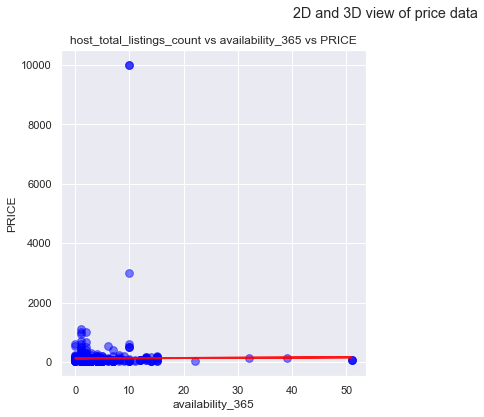

In [60]:
two_vs_three(X_test_slr[:,0],y_test_slr,y_pred_slr,None, True)

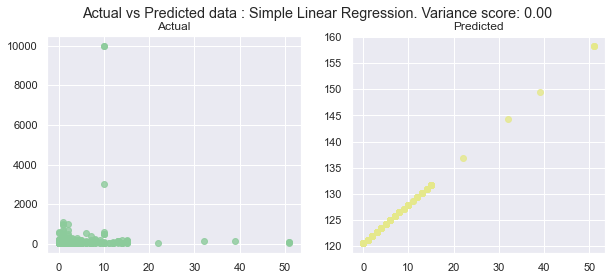

In [61]:
two_d_compare(X_test_slr,y_test_slr,y_pred_slr,model_name)

In [62]:
slrMetrics = model_metrics(slRegressor,y_test_slr,y_pred_slr)

Mean squared error: 286108.78
R2 score: 0.00


## Build multiple linear regression model

In [63]:
room = pd.read_csv("https://raw.githubusercontent.com/alex31425/GEOG594-MTHuang/master/RoomF.csv")
room

host_id  price  number_of_reviews  calculated_host_listings_count  \
0     111468433    161                  0                               1   
1     140139274     39                 16                               5   
2     225508386     39                  1                               1   
3      10213028     55                  5                               2   
4      10213028     55                  8                               2   
...         ...    ...                ...                             ...   
3008    3964809     75                 83                               2   
3009  121967476     79                 95                               2   
3010   21549583     90                  5                               1   
3011    3964809     98                 92                               2   
3012   16071305     49                 35                               1   

      availability_365  host_since_days host_is_superhost  \
0                   89             1396                 f   
1                    0             1217                 f   
2                   87              728                 f   
3                    0             2544                 f   
4                    0             2544                 f   
...                ...              ...               ...   
3008                81             2939                 t   
3009               280             1329                 f   
3010                 0             2243                 f   
3011                24             2939                 t   
3012               178             2358                 f   

      host_total_listings_count host_has_profile_pic host_identity_verified  \
0                             1                    t                      f   
1                             5                    t                      f   
2                             1                    t                      t   
3                             2                    t                      t   
4                             2                    t                      t   
...                         ...                  ...                    ...   
3008                          3                    t                      t   
3009                          2                    t                      t   
3010                          1                    t                      t   
3011                          3                    t                      t   
3012                          1                    t                      t   

      ...  beds  avg_rm  availability_30  availability_60  availability_90  \
0     ...   1.0     1.0               30               60               89   
1     ...   1.0     1.0                0                0                0   
2     ...   1.0     6.0                0                0                0   
3     ...   1.0     1.0                0                0                0   
4     ...   1.0     1.0                0                0                0   
...   ...   ...     ...              ...              ...              ...   
3008  ...   1.0     1.0               22               52               81   
3009  ...   1.0     1.0               24               54               74   
3010  ...   1.0     1.0                0                0                0   
3011  ...   1.0     1.0                0                0               24   
3012  ...   1.0     1.0                0                0                0   

      number_of_reviews_ltm  instant_bookable  NumberOfVerfication  \
0                         0                 f                    1   
1                         0                 f                    6   
2                         1                 t                    6   
3                         0                 f                    7   
4                         0                 f                    7   
...                     ...               ..

In [64]:
#remove columns that are not required
room = room.drop(['host_id'], axis=1)
room = room.dropna()
room.head()

price  number_of_reviews  calculated_host_listings_count  availability_365  \
0    161                  0                               1                89   
1     39                 16                               5                 0   
2     39                  1                               1                87   
3     55                  5                               2                 0   
4     55                  8                               2                 0   

   host_since_days host_is_superhost  host_total_listings_count  \
0             1396                 f                          1   
1             1217                 f                          5   
2              728                 f                          1   
3             2544                 f                          2   
4             2544                 f                          2   

  host_has_profile_pic host_identity_verified  accommodates  ...  beds  \
0                    t                      f             2  ...   1.0   
1                    t                      f             1  ...   1.0   
2                    t                      t             4  ...   1.0   
3                    t                      t             2  ...   1.0   
4                    t                      t             1  ...   1.0   

   avg_rm  availability_30  availability_60  availability_90  \
0     1.0               30               60               89   
1     1.0                0                0                0   
2     6.0                0                0                0   
3     1.0                0                0                0   
4     1.0                0                0                0   

   number_of_reviews_ltm  instant_bookable  NumberOfVerfication  \
0                      0                 f                    1   
1                      0                 f                    6   
2                      1                 t                    6   
3                      0                 f                    7   
4                      0                 f                    7   

  govermentIdentification  numberofamentities  
0                      no                  15  
1                      no                  19  
2                     yes                  45  
3                     yes                  41  
4                     yes                  40  

[5 rows x 22 columns]

In [65]:
room.isnull().any()

price                             False
number_of_reviews                 False
calculated_host_listings_count    False
availability_365                  False
host_since_days                   False
host_is_superhost                 False
host_total_listings_count         False
host_has_profile_pic              False
host_identity_verified            False
accommodates                      False
bathrooms                         False
bedrooms                          False
beds                              False
avg_rm                            False
availability_30                   False
availability_60                   False
availability_90                   False
number_of_reviews_ltm             False
instant_bookable                  False
NumberOfVerfication               False
govermentIdentification           False
numberofamentities                False
dtype: bool

In [66]:
# Defining the categorical columns 
categoricalColumns = room.select_dtypes(include=[np.object]).columns

print("Categorical columns : " )
print(categoricalColumns)

onehot_categorical =  OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[('onehot',onehot_categorical)])

Categorical columns : 
Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'instant_bookable', 'govermentIdentification'],
      dtype='object')


In [68]:
# Defining the numerical columns 
numericalColumns = [col for col in room.select_dtypes(include=[np.int64]).columns if col not in ['price']]
print("Numerical columns : " )
print(numericalColumns)

scaler_numerical = StandardScaler()

numerical_transformer = Pipeline(steps=[('scale',scaler_numerical)])

Numerical columns : 
['number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'host_since_days', 'host_total_listings_count', 'accommodates', 'availability_30', 'availability_60', 'availability_90', 'number_of_reviews_ltm', 'NumberOfVerfication', 'numberofamentities']


In [70]:
preprocessorForCategoricalColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns)],
                                            remainder="passthrough")
preprocessorForAllColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns),('num',numerical_transformer,numericalColumns)],
                                            remainder="passthrough")


#. The transformation happens in the pipeline. Temporarily done here to show what intermediate value looks like
df_pd_temp = preprocessorForCategoricalColumns.fit_transform(room)
print("Data after transforming :")
print(df_pd_temp)

df_pd_temp_2 = preprocessorForAllColumns.fit_transform(room)
print("Data after transforming :")
print(df_pd_temp_2)

Data after transforming :
[[ 1.  0.  0. ...  0.  1. 15.]
 [ 1.  0.  0. ...  0.  6. 19.]
 [ 1.  0.  0. ...  1.  6. 45.]
 ...
 [ 1.  0.  0. ...  0.  7. 21.]
 [ 0.  1.  0. ...  4.  4. 25.]
 [ 1.  0.  0. ...  0.  6. 22.]]
Data after transforming :
[[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 2. 1. 6.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]]


In [71]:
features = []
features = room.drop(['price'], axis=1)

label = pd.DataFrame(room, columns = ['price']) 
label_encoder = LabelEncoder()
label = room['price']

label = label_encoder.fit_transform(label)
print(" value of label : " + str(label))

 value of label : [120  22  22 ...  73  80  32]


In [72]:
X_train, X_test, y_train, y_test = train_test_split(features,label , random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(2225, 21) Output label(2225,)
Dimensions of datasets that will be used for testing : Input features(742, 21) Output label(742,)


In [73]:
from sklearn.linear_model import LinearRegression

model_name = 'Multiple Linear Regression'

mlRegressor = LinearRegression()

mlr_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('regressor', mlRegressor)])

mlr_model.fit(X_train,y_train)

y_pred_mlr= mlr_model.predict(X_test)

print(mlRegressor)

LinearRegression()


In [74]:
print('Intercept: \n',mlRegressor.intercept_)
print('Coefficients: \n', mlRegressor.coef_)

Intercept: 
 21324631492184.93
Coefficients: 
 [-1.55723252e+14 -1.55723252e+14 -2.79210194e+12 -2.79210194e+12
  1.40522377e+14  1.40522377e+14 -5.94283728e+11 -5.94283728e+11
 -2.73737073e+12 -2.73737073e+12 -4.24558851e+00  1.13232236e+00
 -1.08569317e+00  2.06409278e+00  2.12633105e+00  1.14877698e+01
  6.77319734e+00  1.42333984e-01 -7.76367188e-01 -1.57812500e+00
 -3.28515625e+00 -2.09375000e+00 -1.34717517e+09 -1.34717517e+09
 -1.34717516e+09  4.04152551e+09]


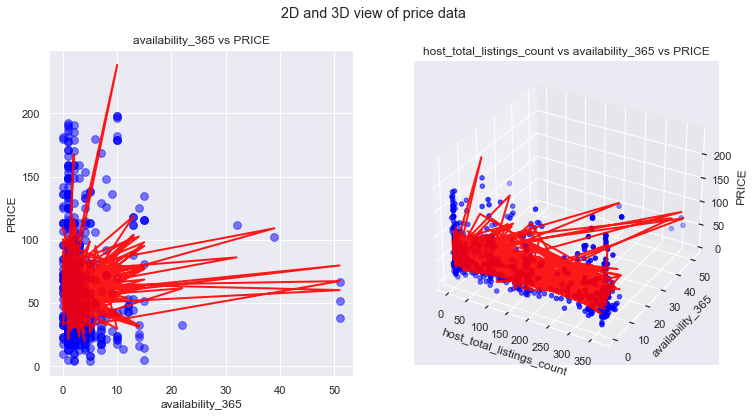

In [75]:
two_vs_three(X_test['host_total_listings_count'],y_test,y_pred_mlr,X_test['availability_365'], False)

In [76]:
mlrMetrics = model_metrics(slRegressor,y_test,y_pred_mlr)

Mean squared error: 1355.35
R2 score: 0.18


## Build Polynomial Linear regression model


The prediction line generated by simple/linear regression is usually a straight line. In cases when a simple or multiple linear regression does not fit the data point accurately, we use the polynomial linear regression. The following formula is used in the back-end to generate polynomial linear regression.

y = w0 + w1x1 + w2x21 + .... + wn*xnn

We are assuming that output depends on the availability_365 and host_total_listings_count. Data is split up into training and test sets.

In [77]:
features.head()

number_of_reviews  calculated_host_listings_count  availability_365  \
0                  0                               1                89   
1                 16                               5                 0   
2                  1                               1                87   
3                  5                               2                 0   
4                  8                               2                 0   

   host_since_days host_is_superhost  host_total_listings_count  \
0             1396                 f                          1   
1             1217                 f                          5   
2              728                 f                          1   
3             2544                 f                          2   
4             2544                 f                          2   

  host_has_profile_pic host_identity_verified  accommodates  bathrooms  ...  \
0                    t                      f             2        1.0  ...   
1                    t                      f             1        1.0  ...   
2                    t                      t             4       15.0  ...   
3                    t                      t             2        1.0  ...   
4                    t                      t             1        1.0  ...   

   beds  avg_rm  availability_30  availability_60  availability_90  \
0   1.0     1.0               30               60               89   
1   1.0     1.0                0                0                0   
2   1.0     6.0                0                0                0   
3   1.0     1.0                0                0                0   
4   1.0     1.0                0                0                0   

   number_of_reviews_ltm  instant_bookable NumberOfVerfication  \
0                      0                 f                   1   
1                      0                 f                   6   
2                      1                 t                   6   
3                      0                 f                   7   
4                      0                 f                   7   

   govermentIdentification numberofamentities  
0                       no                 15  
1                       no                 19  
2                      yes                 45  
3                      yes                 41  
4                      yes                 40  

[5 rows x 21 columns]

In [78]:
X = features.iloc[:, [2,5]].values
X_train, X_test, y_train, y_test = train_test_split(X,label, random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))


Dimensions of datasets that will be used for training : Input features(2225, 2) Output label(2225,)
Dimensions of datasets that will be used for testing : Input features(742, 2) Output label(742,)


In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

model_name = 'Polynomial Linear Regression'

polynomial_features= PolynomialFeatures(degree=3)
plRegressor = LinearRegression()

plr_model = Pipeline(steps=[('polyFeature',polynomial_features ),('regressor', plRegressor)])

plr_model.fit(X_train,y_train)

y_pred_plr= plr_model.predict(X_test)

print(plRegressor)

LinearRegression()


In [80]:
print('Intercept: \n',plRegressor.intercept_)
print('Coefficients: \n', plRegressor.coef_)

Intercept: 
 58.328867611848125
Coefficients: 
 [ 0.00000000e+00  1.15741247e-01 -4.77512436e-01 -1.10445201e-03
  1.19897141e-02  2.12895475e-02  2.30330261e-06 -3.39043870e-05
  7.87840108e-07 -5.34244565e-05]


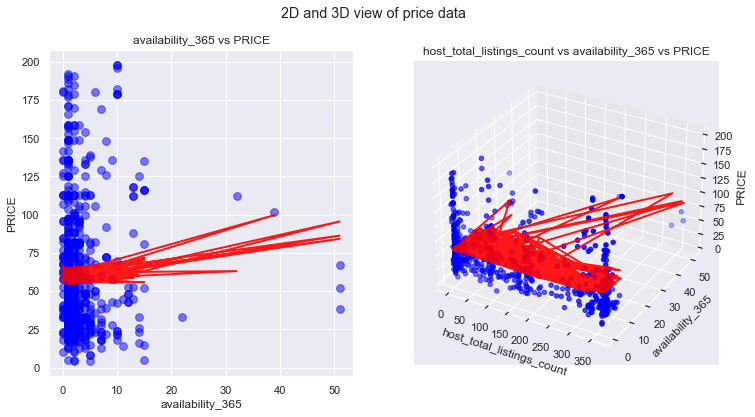

In [81]:
two_vs_three(X_test[:,1],y_test,y_pred_plr,X_test[:,0], False)

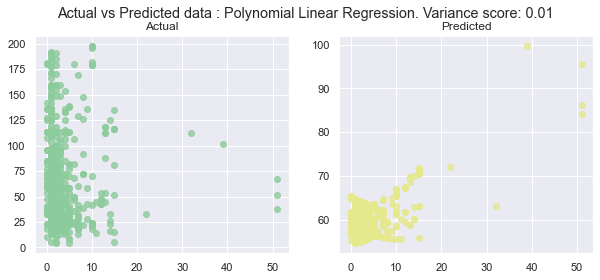

In [82]:
two_d_compare(X_test[:,1],y_test,y_pred_plr,model_name)

In [83]:
plrMetrics = model_metrics(plRegressor,y_test,y_pred_plr)

Mean squared error: 1635.05
R2 score: 0.01


## Build decision tree regressor

In [85]:
X_train, X_test, y_train, y_test = train_test_split(features,room['price'] , random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(2225, 21) Output label(2225,)
Dimensions of datasets that will be used for testing : Input features(742, 21) Output label(742,)


In [86]:
from sklearn.tree import DecisionTreeRegressor

model_name = "Decision Tree Regressor"

decisionTreeRegressor = DecisionTreeRegressor(random_state=0,max_features=25)

dtr_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('regressor', decisionTreeRegressor)]) 

dtr_model.fit(X_train,y_train)

y_pred_dtr = dtr_model.predict(X_test)

print(decisionTreeRegressor)

DecisionTreeRegressor(max_features=25, random_state=0)


In [87]:
export_graphviz(decisionTreeRegressor, out_file ='tree.dot')  
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
# graph.write_png('tree.png')

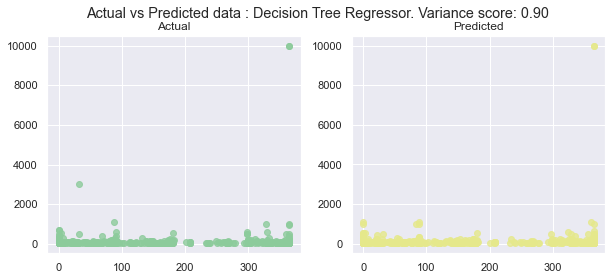

In [88]:
two_d_compare(X_test['availability_365'],y_test,y_pred_dtr,model_name)

In [90]:
dtrMetrics = model_metrics(decisionTreeRegressor,y_test,y_pred_dtr)

Mean squared error: 29064.97
R2 score: 0.90


## Build Random Forest classification model

In [91]:
from sklearn.ensemble import RandomForestRegressor

model_name = "Random Forest Regressor"

randomForestRegressor = RandomForestRegressor(n_estimators=100, max_depth=15,random_state=0)

rfr_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('regressor', randomForestRegressor)]) 

rfr_model.fit(X_train,y_train)

y_pred_rfr = rfr_model.predict(X_test)

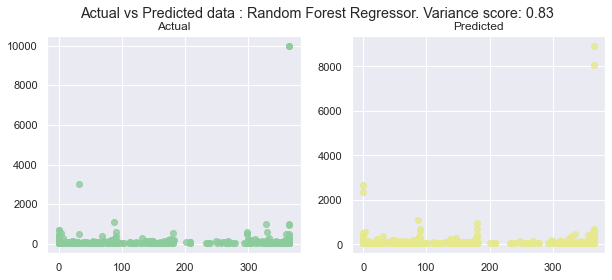

In [92]:
two_d_compare(X_test['availability_365'],y_test,y_pred_rfr,model_name)

In [93]:
rfrMetrics = model_metrics(randomForestRegressor,y_test,y_pred_rfr)

Mean squared error: 47366.01
R2 score: 0.83


## Build XGBoost model

In [94]:
model_name = "XGBoost"

xgboost = XGBClassifier()

xg_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('regressor', xgboost)])

xg_model.fit(X_train, y_train)

y_pred_xg = xg_model.predict(X_test)

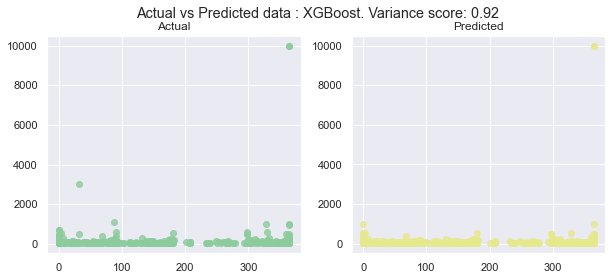

In [95]:
two_d_compare(X_test['availability_365'],y_test,y_pred_xg,model_name)

In [96]:
xgMetrics = model_metrics(xgboost,y_test,y_pred_xg)

Mean squared error: 23818.78
R2 score: 0.92


## Comparative study of different regression algorithms

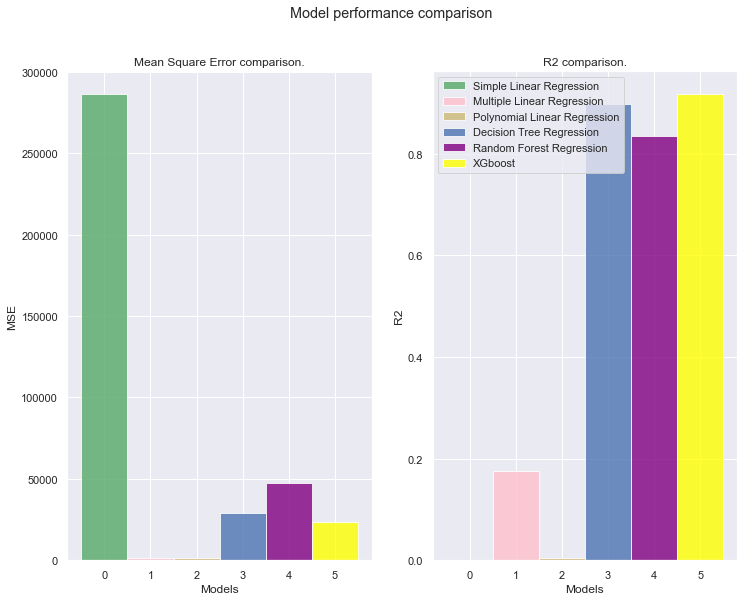

In [97]:
n_groups = 1
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8


area = 70
plt.subplots(ncols=2, figsize=(12,9))
plt.suptitle('Model performance comparison')

plt.subplot(121)
index = np.arange(n_groups)
bar_width = 1
opacity = 0.8

rects1 = plt.bar(index, slrMetrics[0], bar_width,
alpha=opacity,
color='g',
label='Simple Linear Regression')

rects2 = plt.bar(index + bar_width, mlrMetrics[0], bar_width,
alpha=opacity,
color='pink',
label='Multiple Linear Regression')

rects3 = plt.bar(index + bar_width*2, plrMetrics[0], bar_width,
alpha=opacity,
color='y',
label='Polynomial Linear Regression')

rects4 = plt.bar(index + bar_width*3, dtrMetrics[0], bar_width,
alpha=opacity,
color='b',
label='Decision Tree Regression')


rects6 = plt.bar(index + bar_width*4, rfrMetrics[0], bar_width,
alpha=opacity,
color='purple',
label='Random Forest Regression')

rects7 = plt.bar(index + bar_width*5, xgMetrics[0], bar_width,
alpha=opacity,
color='yellow',
label='XGBoost')

plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Mean Square Error comparison.')
# ax.set_xticklabels(('', 'Simple Lin', 'Multiple Lin', 'Polynomial Lin', 'Decision Tree','Random Forest','XGboost'))

plt.subplot(122)

rects1 = plt.bar(index, slrMetrics[1], bar_width,
alpha=opacity,
color='g',
label='Simple Linear Regression')

rects2 = plt.bar(index + bar_width, mlrMetrics[1], bar_width,
alpha=opacity,
color='pink',
label='Multiple Linear Regression')

rects3 = plt.bar(index + bar_width*2, plrMetrics[1], bar_width,
alpha=opacity,
color='y',
label='Polynomial Linear Regression')

rects4 = plt.bar(index + bar_width*3, dtrMetrics[1], bar_width,
alpha=opacity,
color='b',
label='Decision Tree Regression')


rects6 = plt.bar(index + bar_width*4, rfrMetrics[1], bar_width,
alpha=opacity,
color='purple',
label='Random Forest Regression')

rects7 = plt.bar(index + bar_width*5, xgMetrics[1], bar_width,
alpha=opacity,
color='yellow',
label='XGboost')


plt.xlabel('Models')
plt.ylabel('R2')
plt.title('R2 comparison.')
# ax.set_xticklabels(('', 'Simple Lin', 'Multiple Lin', 'Polynomial Lin', 'Decision Tree','Random Forest','XGBoost'))



plt.legend()
plt.show()

## Feature importance

In [99]:
room = pd.read_csv("https://raw.githubusercontent.com/alex31425/GEOG594-MTHuang/master/RoomF.csv")
room.drop(['host_id'],axis=1,inplace=True)
room = pd.get_dummies(room, columns=objcolumn)
room = room.dropna()
df_room = pd.DataFrame.from_records(room.values)
X = df_room.iloc[:, 1:].to_numpy()
y = df_room.iloc[:, 0].to_numpy()

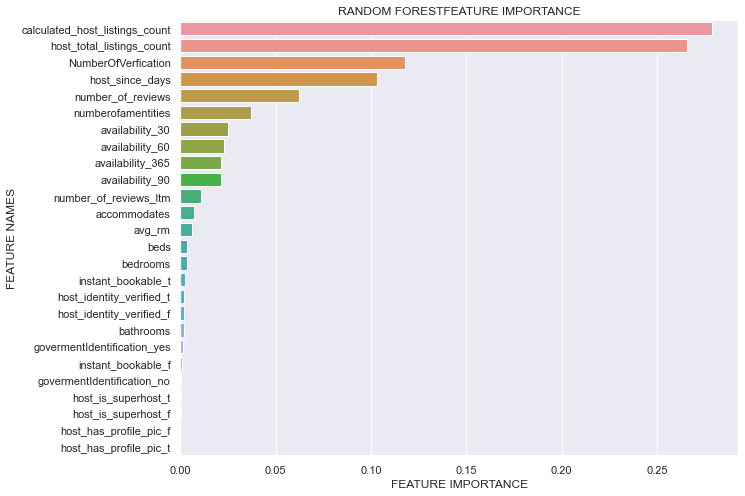

In [100]:
model_RFR = RandomForestRegressor()
importance_RFR = model_RFR.fit(X, y).feature_importances_

feature = []
score = []
for i, v in enumerate(importance_RFR):
    feature.append(f[i])
    score.append(round(v, 5))

plot_feature_importance(importance_RFR,feature,'RANDOM FOREST')

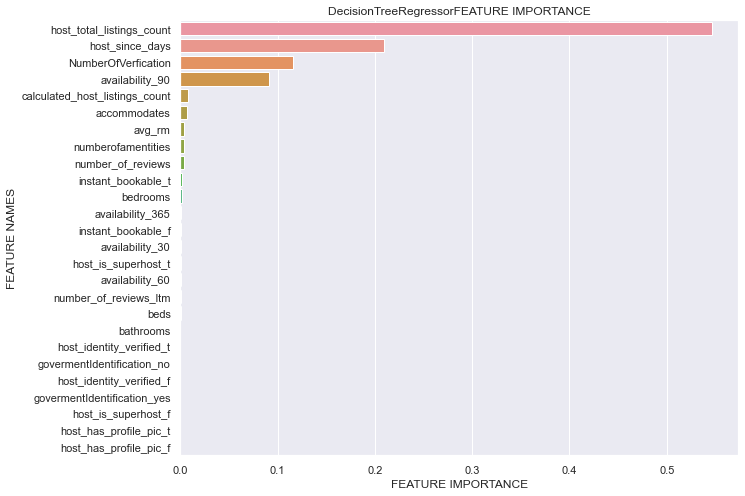

In [101]:
model_DTR = DecisionTreeRegressor()
importance_DTR = model_DTR.fit(X, y).feature_importances_

feature = []
score = []
for i, v in enumerate(importance_DTR):
    feature.append(f[i])
    score.append(round(v, 5))
plot_feature_importance(importance_DTR,feature,'DecisionTreeRegressor')